In [114]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

In [115]:
def e_integrand(zeta, m_e, T_values):
    integrand = np.zeros((len(T_values), len(zeta)))
    
    for i in range(len(T_values)):
        T = T_values[i]
        for j in range(len(zeta)):
            integrand[i, j] = (zeta[j]**2 * np.sqrt(zeta[j]**2 + (m_e / T)**2)) / (np.exp(np.sqrt(zeta[j]**2 + (m_e / T)**2)) + 1) * np.exp(zeta[j])
    
    return integrand

x_gauss,w_gauss = np.polynomial.laguerre.laggauss(40)

This function below allows us to calcualte dQ/dt and the enegery density in neutrinos (pv) from the mass file. Takes the name of the mass file as an input and the name of the saved file you would like to be created.

In [127]:
def imp_values(filename,saved_file):
    actual_data= np.load(filename, allow_pickle=True)
    f_array = actual_data['fe']
    e_array = actual_data['e']
    temp_cm = actual_data['Tcm']
    m_s = actual_data['mass']#in MeV
    t = actual_data['time'] #inverse MeV
    a = actual_data['scalefactors']
    life = actual_data['lifetime']/(6.58*10**-25)*1/1000 #seconds need to be converted to inverse MeV
    temp = actual_data['temp'] #units of MeV
    decay = actual_data['decayrate']
    coll = actual_data['collisionrate']
    p_n = actual_data['p_n_rate']
    n_p = actual_data['n_p_rate']
    mix = actual_data['mixing']
    T_0 = temp[0]
    roww = len(temp)
    
    
    eta_0 = 6.1e-10
    fail_safe = 1
               
               
    D = (10.75/61.75)
    Rz_3 = 1.202056901178332
    n_s = D*(3*Rz_3/(2*np.pi**2))*(temp_cm)**3*np.exp(-t/life)
    ns_initial = n_s[0]
    
    
    m_pl = (1.2*10**19)*1000 #planck mass in MeV
    m_e = 0.510 #electron mass in MeV
    
    
    p_y = (np.pi**2/15)*(temp)**4
    p_vs = m_s*n_s

    results = []
    for e,f in zip(e_array,f_array):
        result = np.trapz(e**3*f,e)
        results.append(result)
        
    p_v = 6*((temp_cm)**4/(2*np.pi**2))*results #in units of MeV^4
    
    
    integrand_vals = np.zeros((len(e_integrand(x_gauss,0.510,temp)),len(w_gauss)))
    vals = e_integrand(x_gauss,m_e,temp)
    
    for i in range(len(integrand_vals)):
        V = vals[i]
        for j in range(len(w_gauss)):
            integrand_vals[i,j] = (2*(temp[j])**4/(np.pi)**2)*V[j]*w_gauss[j]
            
    sums_array = []
    for subarray in integrand_vals:
        subarray_sum = 0
        for i in subarray:
            subarray_sum += i
        sums_array.append(subarray_sum)
   
    p_e = sums_array
    p = p_e+p_y+p_v+p_vs
    
    da = np.sqrt(8*np.pi/(3*m_pl**2))*a/(p)**(-1/2)
    
    results_1 = []
    for e,dec,col in zip(e_array,decay,coll):
        result_1 = np.trapz(e**3*(dec+col),e)
        results_1.append(result_1)
    
    dQ = (m_s*n_s*a**3/life)-(temp_cm**4*a**3/(2*np.pi**2))*da*results_1 #in units of MeV^5
    
    dqdt = dQ/a**3 #converts to MeV^4/sec
    
    
   
    np.savez(saved_file, T = temp, Tcm = temp_cm, dQdt = dqdt, pn = p_n, np = n_p, rhonu = p_v, T_initial = T_0, eta_initial = eta_0, failsafe = fail_safe, ns_0 = ns_initial, vs_mass = m_s, mix_ang = mix, row = roww)

    return dqdt,p_v,p_e
    
    

In [128]:
a,b,c = imp_values("mass-300-life-0.030-new.npz","please_shortlived_vals")

In [130]:
print(a)

[ 5.67898407e-16  5.53659023e-16  5.36917828e-16  5.20134057e-16
  5.03552059e-16  4.87073219e-16  4.70764907e-16  4.54617525e-16
  4.38630853e-16  4.22882413e-16  4.07184630e-16  3.91724231e-16
  3.76446278e-16  3.61297797e-16  3.46491831e-16  3.31743851e-16
  3.17231884e-16  3.02928414e-16  2.88867063e-16  2.74939462e-16
  2.61267178e-16  2.47741883e-16  2.34589780e-16  2.21587621e-16
  2.08751625e-16  1.96296510e-16  1.84012229e-16  1.72018581e-16
  1.60209768e-16  1.48711750e-16  1.37399321e-16  1.26461580e-16
  1.15679257e-16  1.05542588e-16  9.55248536e-17  8.57831468e-17
  7.70300405e-17  6.90566751e-17  6.11583852e-17  5.36596627e-17
  4.68694844e-17  4.27983170e-17  3.94587109e-17  3.50442353e-17
  3.10911180e-17  2.74553160e-17  2.46115635e-17  2.25041503e-17
  2.01079272e-17  1.77857786e-17  1.56473814e-17  1.39109527e-17
  1.24865795e-17  1.11825183e-17  1.03502428e-17  9.19131287e-18
  8.09257318e-18  7.19521949e-18  6.19353928e-18  5.26352202e-18
  4.59386303e-18  4.01607

In [132]:
T_reversed = temp[::-1]

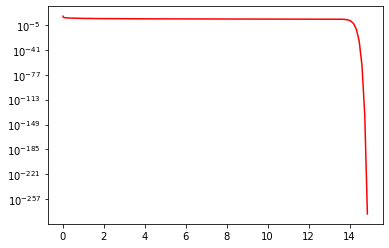

In [135]:
plt.figure()
plt.semilogy(T_reversed,c/T_reversed,color='red')
plt.show()